In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np

In [ ]:
pd.set_option('display.max_columns', None)  # show all columns
pd.set_option('display.width', 200)         # adjust based on terminal width
pd.set_option('display.float_format', '{:.5f}'.format)  # float precision
pd.set_option("display.precision", 5)

In [ ]:
# Mount Google Drive
drive.mount('/content/gdrive')

# Load the dataset (Excel file)
file_path = '/content/gdrive/My Drive/xtdata.csv'
xT = pd.read_csv(file_path)

Mounted at /content/gdrive


In [ ]:
file_path = '/content/gdrive/My Drive/Riskv13.csv'
risk = pd.read_csv(file_path)

In [ ]:
file_path = '/content/gdrive/My Drive/xtdatasucc.csv'
succ = pd.read_csv(file_path)

In [ ]:
xt = xT[["original_event_id","team_name", "xT", "xT_unsucc", "start_x", "start_y", 'end_x', 'end_y']]

In [ ]:
# Perform the left join on 'original_event_id'
merged_df = pd.merge(
    risk,
    xt,
    on='original_event_id',
    how='left'
)

In [ ]:
merged_df = pd.merge(
    merged_df,
    succ[['original_event_id', 'xT_succ']],
    on='original_event_id',
    how='left'
)

In [ ]:
# Select the desired columns
ready_df = merged_df[[
    'game_id',
    'original_event_id',
    'team_name',
    'player_id',
    'player_name',
    'starting_position',
    'result_id',
    'predicted_class',
    'predicted_prob',
    'xT',
    'xT_unsucc',
    'xT_succ',
    'start_x',
    'start_y',
    'end_x',
    'end_y'
]].copy()

In [ ]:
# Group by player and calculate sum, count, and mean of xT
xT_by_player = ready_df.groupby("player_name")["xT"].agg(
    total_xT="sum",
    num_passes="count",
    avg_xT="mean"
).reset_index()

xT_by_player = xT_by_player[xT_by_player['num_passes'] > 50].copy()


# Sort by total xT descending
xT_by_player = xT_by_player.sort_values("total_xT", ascending=False)

# Display top 20 players
print(xT_by_player.head(20))

xT_by_player.to_excel('/content/gdrive/MyDrive/xt_sum_Top.xlsx')

#### STANDARD DEV

In [ ]:
ready_df1 = ready_df.copy()

# Step 0: Compute expected return for each pass
ready_df1["expected_return"] = (
    ready_df1["predicted_prob"] * ready_df1["xT_succ"] +
    (1 - ready_df1["predicted_prob"]) * ready_df1["xT_unsucc"]
)

# Step 1: Group by player and aggregate expected return, xT, and pass count
player_stats = ready_df1.groupby("player_name").agg(
    Expected_return=("expected_return", "sum"),
    total_xT=("xT", "sum"),
    num_passes=("xT", "count")
)

# Remove players with fewer than 50 passes
player_stats = player_stats[player_stats['num_passes'] > 50].copy()

# Step 2: Calculate average xT and average expected return per player
player_stats["avg_xT"] = player_stats["total_xT"] / player_stats["num_passes"]
player_stats["avg_Expected_return"] = player_stats["Expected_return"] / player_stats["num_passes"]

# Step 3: Merge avg_Expected_return back into ready_df1
ready_df1 = ready_df1.merge(player_stats[["avg_Expected_return"]], on="player_name", how="left")

# Step 4: Calculate squared deviations from player's average expected return
ready_df1["squared_diff"] = (ready_df1["xT"] - ready_df1["avg_Expected_return"])**2

# Step 5: Sum of squared deviations per player
squared_diff_sum = ready_df1.groupby("player_name")["squared_diff"].sum()

# Step 6: Compute sample variance (divide by n - 1)
variance = squared_diff_sum / (player_stats["num_passes"] - 1)
variance = variance.rename("var_xT")

# Step 7: Merge variance into player_stats
player_stats = player_stats.join(variance)

# Reset index to make player_name a regular column
player_stats = player_stats.reset_index()


R² value: 0.23301764547927684
P-value: 3.442506250199646e-12
Slope (beta): 2.501969
Intercept (alpha): -0.000896


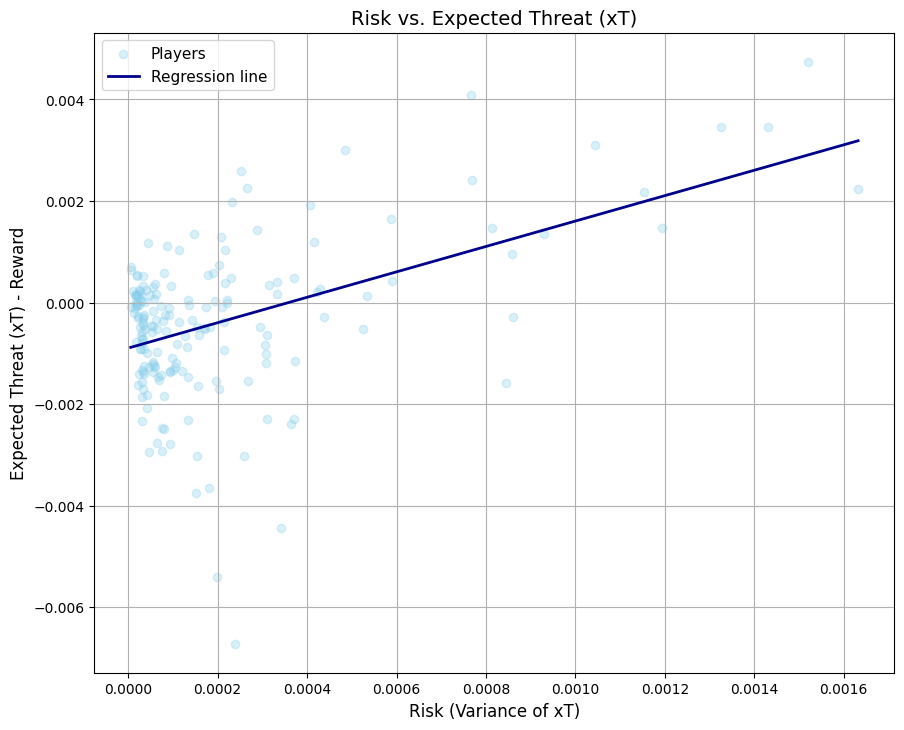

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from scipy import stats

# Prepare data
X = player_stats["var_xT"].values  # Variance of xT (risk)
y = player_stats["avg_xT"].values  # Average xT (reward)

# Fit regression model
model = LinearRegression().fit(X.reshape(-1, 1), y)
slope = model.coef_[0]
intercept = model.intercept_
r_squared = model.score(X.reshape(-1, 1), y)

# Compute p-value using scipy's linregress
slope_, intercept_, r_value, p_value, std_err = stats.linregress(X, y)

# Plot
plt.figure(figsize=(10, 8))

plt.scatter(X, y, alpha=0.3, label="Players", color="skyblue")

# Regression line
x_vals = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
y_vals = model.predict(x_vals)
plt.plot(x_vals, y_vals, color="darkblue", linewidth=2, label="Regression line")

# Print regression details
print("R² value:", r_squared)
print("P-value:", p_value)
print(f"Slope (beta): {slope:.6f}")
print(f"Intercept (alpha): {intercept:.6f}")

# Labels and legend with smaller font sizes
plt.xlabel("Risk (Variance of xT)", fontsize=12)
plt.ylabel("Expected Threat (xT) - Reward", fontsize=12)
plt.title("Risk vs. Expected Threat (xT)", fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=11)
plt.grid(True)

plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

plt.show()


In [ ]:
# Calculate alpha for each player
player_stats["alpha"] = player_stats["avg_xT"] - (slope * player_stats["var_xT"] + intercept)


In [ ]:
# Sort by alpha in descending order
sorted_player_stats = player_stats.sort_values(by='alpha', ascending=True)

import pandas as pd
# Display the players with their alpha values, sorted by alpha
print(sorted_player_stats[['player_name', 'alpha', 'num_passes', 'total_xT', 'var_xT', 'avg_xT']].head(25))

#### Player Categorization

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Set up plot aesthetics
sns.set(style="whitegrid", context="talk")

# Calculate medians for quadrant splitting
median_std = player_stats["var_xT"].median()
median_alpha = player_stats["alpha"].median()

# Define color-coded quadrants
def get_quadrant(row):
    if row["var_xT"] >= median_std and row["alpha"] >= median_alpha:
        return "High Risk - High Reward"
    elif row["var_xT"] < median_std and row["alpha"] >= median_alpha:
        return "Low Risk - High Reward"
    elif row["var_xT"] < median_std and row["alpha"] < median_alpha:
        return "Low Risk - Low Reward"
    else:
        return "High Risk - Low Reward"

player_stats["quadrant"] = player_stats.apply(get_quadrant, axis=1)

# Color palette
palette = {
    "High Risk - High Reward": "#1f77b4",
    "Low Risk - High Reward": "#2ca02c",
    "Low Risk - Low Reward": "#ff7f0e",
    "High Risk - Low Reward": "#d62728"
}

# Plot
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=player_stats,
    x="var_xT",
    y="alpha",
    hue="quadrant",
    palette=palette,
    s=100,
    edgecolor="black"
)

# Add quadrant lines
plt.axhline(median_alpha, color="gray", linestyle="--", linewidth=1)
plt.axvline(median_std, color="gray", linestyle="--", linewidth=1)

# Label standout players
highlighted_players = [
    "Andreas Schjelderup", "Paulo Victor da Silva", "Lukas Lerager",
    "Marcus Ingvartsen", "Alexander Lind", "Adam Gabriel", "Bashkim Kadrii", "Kevin Diks", "Gue-Sung Cho", "Marcus Lindberg"
]
for _, row in player_stats[player_stats["player_name"].isin(highlighted_players)].iterrows():
    plt.text(row["var_xT"] + 0.00001, row["alpha"] + 0.00005,
             row["player_name"], fontsize=10, weight='bold')

# Labels and title
plt.title("Player Passing Styles: Risk vs Risk-Adjusted Reward (Alpha)", fontsize=18)
plt.xlabel("Variance of xT (Risk)", fontsize=14)
plt.ylabel("Alpha (Risk-Adjusted Value)", fontsize=14)
plt.legend(title="Quadrant", fontsize=11, title_fontsize=12)
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Set up plot aesthetics
sns.set(style="whitegrid", context="talk")

# Calculate medians for quadrant splitting
median_passes = player_stats["num_passes"].median()
median_alpha = player_stats["alpha"].median()

# Define quadrants based on volume (x) and value (y)
def get_quadrant(row):
    if row["num_passes"] >= median_passes and row["alpha"] >= median_alpha:
        return "High Volume - High Reward"
    elif row["num_passes"] < median_passes and row["alpha"] >= median_alpha:
        return "Low Volume - High Reward"
    elif row["num_passes"] < median_passes and row["alpha"] < median_alpha:
        return "Low Volume - Low Reward"
    else:
        return "High Volume - Low Reward"

player_stats["quadrant"] = player_stats.apply(get_quadrant, axis=1)

# Color palette
palette = {
    "High Volume - High Reward": "#1f77b4",
    "Low Volume - High Reward": "#2ca02c",
    "Low Volume - Low Reward": "#ff7f0e",
    "High Volume - Low Reward": "#d62728"
}

# Plot
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=player_stats,
    x="num_passes",
    y="alpha",
    hue="quadrant",
    palette=palette,
    s=100,
    edgecolor="black"
)

# Add quadrant lines
plt.axhline(median_alpha, color="gray", linestyle="--", linewidth=1)
plt.axvline(median_passes, color="gray", linestyle="--", linewidth=1)

# Highlight specific players
highlighted_players = [
    "Andreas Schjelderup", "Paulo Victor da Silva", "Lukas Lerager",
    "Marcus Ingvartsen", "Alexander Lind", "Adamo Nagalo", "Bashkim Kadrii",
    "Kevin Diks", "Gue-Sung Cho", "Mark Brink"
]
for _, row in player_stats[player_stats["player_name"].isin(highlighted_players)].iterrows():
    plt.text(row["num_passes"] + 1, row["alpha"] + 0.00005,
             row["player_name"], fontsize=10, weight='bold')

# Labels and title
plt.title("Player Passing Profiles: Volume vs Risk-Adjusted Reward (Alpha)", fontsize=18)
plt.xlabel("Number of Passes", fontsize=14)
plt.ylabel("Alpha (Risk-Adjusted Value)", fontsize=14)
plt.legend(title="Quadrant", fontsize=11, title_fontsize=12)
plt.tight_layout()
plt.show()


In [ ]:
# Get each player's most frequent starting position
player_positions = (
    ready_df.groupby('player_name')['starting_position']
    .agg(lambda x: x.value_counts().idxmax())
    .reset_index()
)

# Merge starting position into player_stats
player_stats_with_position = player_stats.merge(
    player_positions,
    on='player_name',
    how='left'
)

# Calculate average alpha by starting position and count players for each position
avg_alpha_by_position = (
    player_stats_with_position.groupby('starting_position').agg(
        avg_alpha=('alpha', 'mean'),
        num_players=('player_name', 'nunique')
    )
    .reset_index()
    .sort_values(by='avg_alpha', ascending=False)
)

print(avg_alpha_by_position)



#### Team level

In [ ]:
# Step 1: Count passes per player
passes_per_player = (
    ready_df.groupby('player_name')
    .size()
    .reset_index(name='player_num_passes')
)

# Step 2: Total passes per team
passes_per_team = (
    ready_df.groupby('team_name')
    .size()
    .reset_index(name='team_total_passes')
)

# Step 3: Get player-to-team mapping (most frequent team)
player_team_map = (
    ready_df.groupby('player_name')['team_name']
    .agg(lambda x: x.value_counts().idxmax())
    .reset_index()
)

# Step 4: Merge everything into player_stats
player_stats_extended = (
    player_stats
    .merge(passes_per_player, on='player_name', how='left')
    .merge(player_team_map, on='player_name', how='left')
    .merge(passes_per_team, on='team_name', how='left')
)

# Step 5: Compute weight and weighted alpha
player_stats_extended['player_weight'] = (
    player_stats_extended['player_num_passes'] / player_stats_extended['team_total_passes']
)

player_stats_extended['weighted_alpha'] = (
    player_stats_extended['alpha'] * player_stats_extended['player_weight']
)

# Step 6: Compute weighted average alpha per team
weighted_alpha_per_team = (
    player_stats_extended.groupby('team_name')
    .agg(
        weighted_avg_alpha=('weighted_alpha', 'sum'),
        num_players=('player_name', 'nunique')
    )
    .reset_index()
    .sort_values(by='weighted_avg_alpha', ascending=False)
)

print(weighted_alpha_per_team)


#### alpha vs. position

In [ ]:
import pandas as pd

# Create a standings DataFrame manually
standings_df = pd.DataFrame({
    'team_name': [
        'FC Midtjylland', 'Brøndby IF', 'FC København', 'FC Nordsjælland', 'AGF Aarhus', 'Silkeborg IF',
        'Randers FC', 'Viborg FF', 'Vejle BK', 'Lyngby BK', 'Odense Boldklub', 'Hvidovre IF'
    ],
    'position': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
    'Points': [63, 62, 59, 58, 44, 36, 41, 40, 36, 36, 32, 20]
})


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress

# Merge with standings data
alpha_vs_points = weighted_alpha_per_team.merge(
    standings_df,
    on='team_name',
    how='inner'
)

# Linear regression
slope, intercept, r_value, p_value, std_err = linregress(
    alpha_vs_points['position'],
    alpha_vs_points['weighted_avg_alpha']
)

# Create predicted y values for the regression line
regression_line = slope * alpha_vs_points['position'] + intercept

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=alpha_vs_points, x='position', y='weighted_avg_alpha', hue='team_name', s=100)

# Add regression line
plt.plot(alpha_vs_points['position'], regression_line, color='black', linestyle='-')

# Add R² value as text on the plot
plt.text(
    x=alpha_vs_points['position'].min(),
    y=alpha_vs_points['weighted_avg_alpha'].max(),
    s=f'$R^2$ = {r_value**2:.2f}',
    fontsize=12,
    color='black'
)

# Add team labels to each point
for _, row in alpha_vs_points.iterrows():
    plt.text(row['position'] + 0.3, row['weighted_avg_alpha'], row['team_name'], fontsize=9)

# Plot formatting
plt.title('Weighted Alpha vs. Position by Team')
plt.xlabel('League Position')
plt.ylabel('Weighted Alpha')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
plt.grid(True)
plt.tight_layout()
plt.legend().remove()
plt.show()


#### Adjusted alpha

In [ ]:
# Step 1: Merge position info into a new copy of player_stats_extended
player_stats_extended1 = player_stats_extended.merge(
    player_positions,
    on='player_name',
    how='left'
)

# Step 2: Merge in average alpha per position
player_stats_extended1 = player_stats_extended1.merge(
    avg_alpha_by_position[['starting_position', 'avg_alpha']],
    on='starting_position',
    how='left'
).rename(columns={'avg_alpha': 'avg_alpha_position'})

# Step 3: Merge in team weighted average alpha (renamed to avg_alpha_team)
player_stats_extended1 = player_stats_extended1.merge(
    weighted_alpha_per_team[['team_name', 'weighted_avg_alpha']].rename(
        columns={'weighted_avg_alpha': 'avg_alpha_team'}
    ),
    on='team_name',
    how='left'
)

# Step 4: Subtract both effects to calculate adjusted alpha
player_stats_extended1['adjusted_alpha'] = (
    player_stats_extended1['alpha']
    - player_stats_extended1['avg_alpha_position']
    - player_stats_extended1['avg_alpha_team']
)

# Step 5 (Optional): display or sort
cols_to_show = [
    'player_name', 'team_name', 'starting_position', 'player_num_passes', 'avg_xT',
    'alpha', 'avg_alpha_position', 'avg_alpha_team', 'adjusted_alpha'
]


In [ ]:
# Sort by alpha in descending order
player_stats_extended1 = player_stats_extended1.sort_values(by='adjusted_alpha', ascending=False)

x= player_stats_extended1[['player_name', "starting_position", 'alpha', 'num_passes', "adjusted_alpha"]]

player_stats_extended1 = player_stats_extended1.sort_values(by='adjusted_alpha', ascending=True)

y = player_stats_extended1[['player_name', "starting_position", 'team_name', 'alpha', 'num_passes', "adjusted_alpha"]]

x.to_excel('/content/gdrive/MyDrive/adj_alpha_top.xlsx')
y.to_excel('/content/gdrive/MyDrive/adj_alpha_end.xlsx')